Augment the literature data

In [1]:
# Load libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset, data_aug_knn, perform_eval
from modelval.ArbDataGen import arb_w_gen
from modelval.spk_visu import spk_see, raster
from modelval import gp_regressor
from modelval import data_aug_gp
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

% matplotlib inline
% load_ext autoreload
% autoreload 2

In [2]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60


In [3]:
# Generate data for STDP
data1 = data[data['ptl_idx']==1]
data1_gen, targets1 = data_aug_knn.STDP_dw_gen(n_neighbors=3)

In [4]:
# Obtain the gp mean
params = {'amp_kernel': 1,
 'length_scale': 0.1,
 'power_sc': 0.2,
 'sigma_noise': 1.0}

x_stdp, _, x_stdp_test, y_stdp_test, y_stdp = data_aug_gp.stdp_gp(**params)

x_stdp_train, x_stdp_vali, y_stdp_train, y_stdp_vali = train_test_split(x_stdp, y_stdp, test_size=0.2)

[-110, 110, -50, 110]

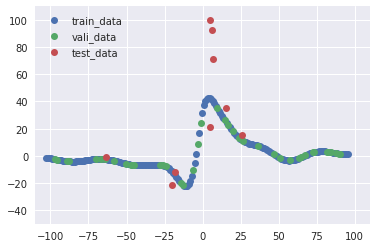

In [5]:
plt.plot(x_stdp_train, y_stdp_train, 'o',label='train_data')
plt.plot(x_stdp_vali, y_stdp_vali, 'o',label='vali_data')
plt.plot(x_stdp_test,y_stdp_test, 'o', label='test_data')
plt.legend(loc='upper left')
plt.axis([-110,110,-50,110])

In [6]:
# Pute time information into dataframe
data_stdp_train = data_aug_gp.STDP_dw_gen(x_stdp_train)
data_stdp_vali = data_aug_gp.STDP_dw_gen(x_stdp_vali)
data_stdp_test = data_aug_gp.STDP_dw_gen(x_stdp_test.reshape(-1,1))

In [7]:
data_stdp_train.shape, y_stdp_train.shape, data_stdp_vali.shape, y_stdp_vali.shape,data_stdp_test.shape, y_stdp_test.shape

((160, 13), (160, 1), (40, 13), (40, 1), (9, 13), (9, 1))

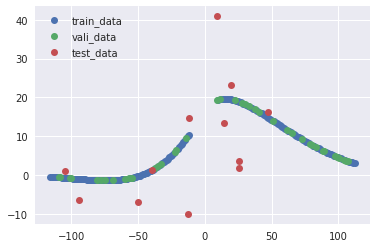

In [8]:
# Obtain augmented data from quadruplet protocol
params = {'amp_kernel': 1,
 'length_scale': 0.45,
 'power_sc': 0.4,
 'sigma_noise': 1.2}

x_quad, _, x_quad_test, y_quad_test, y_quad = data_aug_gp.quad_gp(**params)

# Split into training and validation set
x_quad_train, x_quad_vali, y_quad_train, y_quad_vali = train_test_split(x_quad, y_quad, test_size=0.2)

plt.plot(x_quad_train, y_quad_train, 'o', label='train_data')
plt.plot(x_quad_vali, y_quad_vali, 'o', label='vali_data')
plt.plot(x_quad_test, y_quad_test, 'o', label='test_data')
plt.legend(loc='upper left')

In [9]:
# Put dt information into dataframe
data_quad_train = data_aug_gp.quad_dw_gen(x_quad_train)
data_quad_vali = data_aug_gp.quad_dw_gen(x_quad_vali)
data_quad_test = data_aug_gp.quad_dw_gen(x_quad_test.reshape(-1,1))

In [10]:
data_quad_train.shape, y_quad_train.shape, data_quad_vali.shape, y_quad_vali.shape, data_quad_test.shape, y_quad_test.shape

((160, 13), (160, 1), (40, 13), (40, 1), (12, 13), (12, 1))

In [33]:
# Generate data for Triplet
dt = np.array([-10, -5, 0, 5, 10]).reshape(-1,1)
data_trip, y_trip, data_trip_test, y_trip_test = data_aug_gp.triplet_dw_gen(n_samples=1)

# Split the triplet data into training and validation
np.random.seed(10)
idx = np.random.permutation(len(data_trip))
data_trip_train = data_trip.iloc[idx[:int(len(data_trip)*0.8)]]
y_trip_train = y_trip[idx[:int(len(data_trip)*0.8)]]
data_trip_vali = data_trip.iloc[idx[int(len(data_trip)*0.8):]]
y_trip_vali = y_trip[idx[int(len(data_trip)*0.8):]]

In [36]:
data_trip_train.shape, data_trip_vali.shape, data_trip_test.shape

((6, 13), (2, 13), (11, 13))

In [12]:
# Combine data from stdp and quadruplet
data_gen_train = pd.concat([data_stdp_train, data_trip_train, data_quad_train], axis=0)
y_train = np.concatenate([y_stdp_train, y_trip_train, y_quad_train])
data_gen_vali = pd.concat([data_stdp_vali, data_trip_vali, data_quad_vali], axis=0)
y_vali = np.concatenate([y_stdp_vali, y_trip_vali, y_quad_vali])
data_gen_test = pd.concat([data_stdp_test, data_trip_test, data_quad_test], axis=0)
y_test = np.concatenate([y_stdp_test, y_trip_test, y_quad_test])

In [13]:
data_gen_train.shape, y_train.shape, data_gen_vali.shape, y_vali.shape

((326, 13), (326, 1), (82, 13), (82, 1))

In [14]:
trip_para = pd.read_pickle('/src/Plasticity_Ker/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]

# Visualize kernel
from modelval.kernel import KernelGen
ker_test = KernelGen()

para = trip_para.loc[('Hippo_AlltoAll', 'Full'), :]
a = para[:4].values
tau = para[4:].values
reso_set = 2
tau_pre_post = tau[0]/reso_set  # ms
tau_post_pre = tau[2]/reso_set # ms

len_kernel=101
ker_test = KernelGen(len_kernel=len_kernel)
ker_test.trip_model_ker(para, data_name='Hippocampus')

In [15]:
# Generat the spike trains and targets for STDP
data_hippo = data[data['ptl_idx']<5]
ptl_list = [1,2,3,4]
spk_len = int(data_hippo['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 1
aug_times = [1,1,1,1]
spk_pairs_train, targets_train = arb_w_gen(df=data_gen_train, ptl_list=ptl_list, targets=y_train, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)
spk_pairs_vali, targets_vali = arb_w_gen(df=data_gen_vali, ptl_list=ptl_list, targets=y_vali, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)

In [16]:
# Create the network
ground_truth_init = 0
reg_scale=(10, 1)
init_seed=(4,5,6,7)

toy_data_net = network.TripNet(kernel=ker_test, ground_truth_init=ground_truth_init, reg_scale=reg_scale, n_input=spk_pairs_train.shape[1])

In [17]:
# Create the trainer
save_dir= '/src/Plasticity_Ker/model/Trip_ptl1_4_real_aug_gp_mean_noise_alpha1_10'
toy_net_trainer = trainer.Trainer(toy_data_net.loss, toy_data_net.loss, input_name=toy_data_net.inputs, target_name=toy_data_net.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net.lr})

In [18]:
train_data = dataset.Dataset(spk_pairs_train, targets_train)
vali_data = dataset.Dataset(spk_pairs_vali, targets_vali)

[-0.22614121 -0.27994752  0.95375919] 0.0


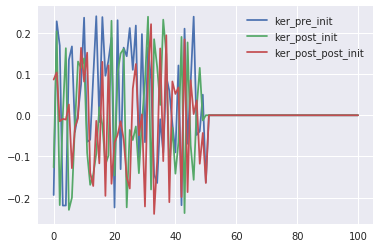

In [19]:
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
w_post_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.plot(w_pre,  label='ker_pre_init')
plt.plot(w_post,  label='ker_post_init')
plt.plot(w_post_post,  label='ker_post_post_init')

plt.legend()
print(fc_w, bias)

In [20]:
# Learn the kernel from random initialization
learning_rate = 0.001
iterations = 5
min_error = -1
for i in range(iterations):
    toy_net_trainer.train(train_data, vali_data, batch_size=128, min_error=min_error, feed_dict={toy_data_net.lr: learning_rate})
    learning_rate = learning_rate/3


Initial validation cost=121.46812
Global Step 0150 and Step 0150: validation cost=88.25510
Updated min validation loss!Saving model...
Global Step 0200 and Step 0200: validation cost=79.79579
Updated min validation loss!Saving model...
Global Step 0250 and Step 0250: validation cost=71.37774
Updated min validation loss!Saving model...
Global Step 0300 and Step 0300: validation cost=63.18383
Updated min validation loss!Saving model...
Global Step 0350 and Step 0350: validation cost=55.31700
Updated min validation loss!Saving model...
Global Step 0400 and Step 0400: validation cost=47.82402
Updated min validation loss!Saving model...
Global Step 0450 and Step 0450: validation cost=40.91585
Updated min validation loss!Saving model...
Global Step 0500 and Step 0500: validation cost=35.22461
Updated min validation loss!Saving model...
Global Step 0550 and Step 0550: validation cost=30.87477
Updated min validation loss!Saving model...
Global Step 0600 and Step 0600: validation cost=28.03623

[array([-1.05497837, -1.00575626,  1.71398866], dtype=float32), 0.21121627]


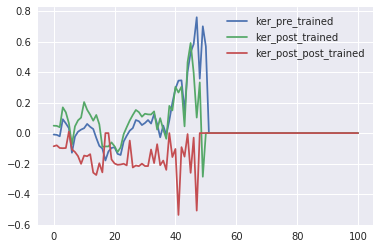

In [28]:
toy_net_trainer.restore_best()
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
w_post_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.plot(-1*w_pre, label='ker_pre_trained')
plt.plot(-1*w_post, label='ker_post_trained')
plt.plot(w_post_post, label='ker_post_post_trained')
plt.legend()
print([fc_w, bias])

In [22]:
# # Test effect of smoothed kernel
# w_pre_sm = w_pre
# w_post_sm = w_post 
# w_post_post_sm = w_post_post
# w_pre_sm[:50] = dw_gen.smooth(w_pre[:50], width=2)
# w_post_sm[:48] = dw_gen.smooth(w_post[:48], width=2)
# w_post_post_sm[:49] = dw_gen.smooth(w_post_post[:49], width=3)

# plt.plot(-1 * w_pre_sm)
# plt.plot(-1 * w_post_sm)
# plt.plot(-1*w_post_post_sm)

# ker_test.kernel_pre = w_pre_sm
# ker_test.kernel_post = w_post_sm
# ker_test.kernel_post_post= w_post_post_sm
# ker_test.kernel_scale = fc_w
# ker_test.bias = bias

Compare the target and prediction

In [29]:
# Updated the kernel as trained kernel
ker_test.kernel_pre = w_pre
ker_test.kernel_post = w_post
ker_test.kernel_post_post= w_post_post
ker_test.kernel_scale = fc_w
ker_test.bias = bias

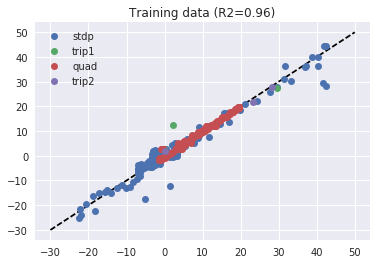

In [38]:
# Generate training predictions
spk_len = int(data['train_len'].max() * 1000 / ker_test.reso_kernel)
_, predictions_train = arb_w_gen(spk_pairs=spk_pairs_train, spk_len=spk_len, kernel=ker_test, net_type='triplet')

ptl_len = np.array([160,3,160,3])
rep_time = np.array([1,1,1,1])
ptl_len, targets_out, predictions_out = data_aug_knn.target_pred_gen(targets_train, predictions_train, ptl_len, rep_time)

# Calculate the total sum of squares
R2 = 1 - np.sum(np.square(predictions_train-targets_train))/(np.square(np.std(targets_train))*(len(targets_train)-1))

plt.plot(np.linspace(-30,50,80), np.linspace(-30,50,80),'k--')
ptl_type = ['stdp', 'trip1', 'quad','trip2']
for i in range(len(ptl_len)):
    plt.plot(targets_out[i], predictions_out[i],'o', label=ptl_type[i])

plt.title('Training data (R2=%0.2f)'%(R2))
plt.legend()

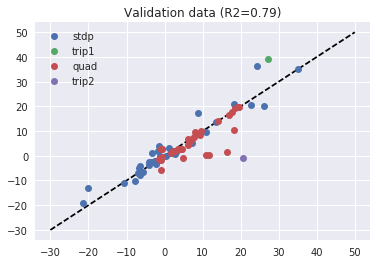

In [39]:
# Generate validation predictions
spk_len = int(data['train_len'].max() * 1000 / ker_test.reso_kernel)
_, predictions_vali = arb_w_gen(spk_pairs=spk_pairs_vali, spk_len=spk_len, kernel=ker_test, net_type='triplet')

ptl_len = np.array([40,1,40,1])
rep_time = np.array([1,1,1,1])
ptl_len, targets_out, predictions_out = data_aug_knn.target_pred_gen(targets_vali, predictions_vali, ptl_len, rep_time)

# Calculate the total sum of squares
R2 = 1 - np.sum(np.square(predictions_vali-targets_vali))/(np.square(np.std(targets_vali))*(len(targets_vali)-1))
corr = np.sqrt(R2)

plt.plot(np.linspace(-30,50,80), np.linspace(-30,50,80),'k--')
ptl_type = ['stdp', 'trip1', 'quad','trip2']
for i in range(len(ptl_len)):
    plt.plot(targets_out[i], predictions_out[i],'o', label=ptl_type[i])

plt.title('Validation data (R2=%0.2f)'%(R2))
plt.legend()

In [26]:
# Generat the spike trains and targets for STDP
data3 = data[data['ptl_idx']==3]
ptl_list = [1,2,3,4]
spk_len = int(data3['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 0
aug_times = [1,1,1,1]
spk_pairs_test, targets_test = arb_w_gen(df=data_gen_test, ptl_list=ptl_list, targets=y_test, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)

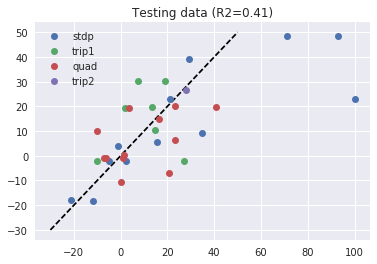

In [41]:
# Generate test predictions
spk_len = int(data['train_len'].max() * 1000 / ker_test.reso_kernel)
_, predictions_test = arb_w_gen(spk_pairs=spk_pairs_test, spk_len=spk_len, kernel=ker_test, net_type='triplet')

ptl_len = np.array([12,7,12,4])
rep_time = np.array([1,1,1,1])
ptl_len, targets_out, predictions_out = data_aug_knn.target_pred_gen(targets_test, predictions_test, ptl_len, rep_time)

# Calculate the total sum of squares
R2 = 1 - np.sum(np.square(predictions_test-targets_test))/(np.square(np.std(targets_test))*(len(targets_test)-1))
corr = np.sqrt(R2)

plt.plot(np.linspace(-30,50,80), np.linspace(-30,50,80),'k--')
ptl_type = ['stdp', 'trip1', 'quad','trip2']
for i in range(len(ptl_len)):
    plt.plot(targets_out[i], predictions_out[i],'o', label=ptl_type[i])

plt.title('Testing data (R2=%0.2f)'%(R2))
plt.legend()